In [36]:
%reload_ext autoreload
%autoreload 2



In [37]:
import sys
from pathlib import Path

# Notebook is in root/code
PROJECT_ROOT = Path.cwd().resolve().parent
CODE_DIR = PROJECT_ROOT / "code"

# Add root/code so we can import `utils.*`
if str(CODE_DIR) not in sys.path:
    sys.path.insert(0, str(CODE_DIR))

# Add project root so `integrao` package can be imported
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import torch

from utils.paths import ProjectPaths
from utils.repro import seed_everything
from utils.config import IntegraoConfig
from utils.io_tcga import load_tcga_brca_pickles
from utils.preprocessing import build_union_views, encode_pam50, select_features_for_views
from utils.integrao_pipeline import run_cv_scenario
from utils.plotting import save_cv_boxplot, save_top_features_barplot
from utils.feature_importance import global_corr_importance

print("Torch CUDA available:", torch.cuda.is_available())


Torch CUDA available: False


In [2]:
seed_everything(42)

cfg = IntegraoConfig(
    neighbor_size=20,
    embedding_dims=64,
    fusing_iteration=30,
    normalization_factor=1.0,
    alignment_epochs=1000,
    beta=1.0,
    mu=0.5,
    n_splits=5,
    random_state=42,
    cluster_number=4,
    n_keep_features=500,
    finetune_epochs=800,
)

dataset_name = "supervised_integration_feature_importance"
paths = ProjectPaths(dataset_name=dataset_name)
paths.ensure()

paths.root, paths.figures_dir, paths.models_dir


(PosixPath('/Users/sofijaorlovic/Desktop/sofka/epfl/ML4science/final_integrao'),
 PosixPath('/Users/sofijaorlovic/Desktop/sofka/epfl/ML4science/final_integrao/results/figures/integrao/supervised_integration_feature_importance'),
 PosixPath('/Users/sofijaorlovic/Desktop/sofka/epfl/ML4science/final_integrao/models/integrao/supervised_integration_feature_importance'))

In [4]:
data_dir = PROJECT_ROOT / "data" / "TCGA-BRCA"
omics = ["mRNA", "DNAm", "RPPA"]

data = load_tcga_brca_pickles(data_dir, omics)
views = build_union_views(data)

labels_1based, pam50_classes = encode_pam50(views.meta_union, label_col="paper_BRCA_Subtype_PAM50")
print("PAM50 classes:", pam50_classes)
print("Label counts:\n", labels_1based.value_counts())


PAM50 classes: ['Basal', 'Her2', 'LumA', 'LumB']
Label counts:
 cluster_id
3    352
4    138
1    119
2     49
Name: count, dtype: int64


In [5]:
raw_views = {"dna": views.dna, "rna": views.rna, "rppa": views.rppa}
fs_views, feat_lists = select_features_for_views(raw_views, n_keep=cfg.n_keep_features)

print(fs_views["rna"].shape, fs_views["dna"].shape, fs_views["rppa"].shape)


(658, 500) (658, 500) (658, 464)


In [6]:
# CV should run on labelled subjects only
labelled_ids = pd.Index(labels_1based.index, name="subjects")

# Also restrict to subjects existing in at least one view index (safety)
for m in ["rna", "dna", "rppa"]:
    labelled_ids = labelled_ids.intersection(fs_views[m].index)

labelled_ids[:5], len(labelled_ids)


(Index(['TCGA-3C-AALI', 'TCGA-3C-AALJ', 'TCGA-3C-AALK', 'TCGA-4H-AAAK',
        'TCGA-5L-AAT1'],
       dtype='object'),
 658)

# Union-Union

Start indexing input expression matrices!
Common sample between view0 and view1: 327
Common sample between view0 and view2: 326
Common sample between view1 and view2: 328
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 6.315636873245239s
Starting unsupervised exmbedding extraction!
Dataset 0: (398, 500)
Dataset 1: (398, 500)
Dataset 2: (395, 464)
epoch 0: loss 28.41858673095703, align_loss:0.674492
epoch 100: loss 22.75909423828125, align_loss:0.383848
epoch 200: loss 1.7214388847351074, align_loss:0.199153
epoch 300: loss 1.7204357385635376, align_loss:0.198407
epoch 400: loss 1.7192851305007935, align_loss:0.197650
epoch 500: loss 1.7179912328720093, align_loss:0.196855
epoch 600: loss 1.7165751457214355, align_loss:0.196081
epoch 700: loss 1.7150497436523438, align_loss:0.195294
epoch 800: loss 1.7134183645248413, align_loss:0.194526
epoch 900: loss 1.7116711139678955, align_loss:0.193717
Manifold alignment ends! Times: 17.17495608329773s
Starting supervised finet

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/supervised_train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


epoch 0: loss 5.0421600341796875, kl_loss:2.842150, align_loss:0.750176, clf_loss:1.449834
epoch 100: loss 2.088304042816162, kl_loss:1.686368, align_loss:0.171408, clf_loss:0.230528
epoch 200: loss 1.9184943437576294, kl_loss:1.652046, align_loss:0.166725, clf_loss:0.099723
epoch 300: loss 1.8792473077774048, kl_loss:1.648337, align_loss:0.166394, clf_loss:0.064516
epoch 400: loss 1.8600420951843262, kl_loss:1.644491, align_loss:0.165632, clf_loss:0.049919
epoch 500: loss 1.840672254562378, kl_loss:1.639025, align_loss:0.165346, clf_loss:0.036301
epoch 600: loss 1.8251441717147827, kl_loss:1.633364, align_loss:0.164890, clf_loss:0.026890
epoch 700: loss 1.8119319677352905, kl_loss:1.626570, align_loss:0.164692, clf_loss:0.020670
Manifold alignment ends! Times: 20.003124952316284s
Start indexing input expression matrices!
Common sample between view0 and view1: 415
Common sample between view0 and view2: 414
Common sample between view1 and view2: 414
Neighbor size: 20
Start applying diff

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/integrater.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loc

Common sample between view0 and view2: 330
Common sample between view1 and view2: 326
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 5.6272101402282715s
Starting unsupervised exmbedding extraction!
Dataset 0: (397, 500)
Dataset 1: (397, 500)
Dataset 2: (400, 464)
epoch 0: loss 28.581928253173828, align_loss:0.760952
epoch 100: loss 22.769596099853516, align_loss:0.393142
epoch 200: loss 1.7250385284423828, align_loss:0.201191
epoch 300: loss 1.7235599756240845, align_loss:0.200484
epoch 400: loss 1.721832513809204, align_loss:0.199667
epoch 500: loss 1.719904899597168, align_loss:0.198691
epoch 600: loss 1.7177989482879639, align_loss:0.197705
epoch 700: loss 1.7155321836471558, align_loss:0.196578
epoch 800: loss 1.7130879163742065, align_loss:0.195506
epoch 900: loss 1.7104716300964355, align_loss:0.194221
Manifold alignment ends! Times: 17.031888008117676s
Starting supervised fineting!
Dataset 0: (397, 500)
Dataset 1: (397, 500)
Dataset 2: (400, 464)
IntegrAO(
  

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/supervised_train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


epoch 100: loss 2.0721921920776367, kl_loss:1.698073, align_loss:0.177962, clf_loss:0.196157
epoch 200: loss 1.873169183731079, kl_loss:1.666471, align_loss:0.165360, clf_loss:0.041338
epoch 300: loss 1.8649379014968872, kl_loss:1.662102, align_loss:0.165103, clf_loss:0.037733
epoch 400: loss 1.855860710144043, kl_loss:1.656500, align_loss:0.165321, clf_loss:0.034039
epoch 500: loss 1.845857858657837, kl_loss:1.650943, align_loss:0.164999, clf_loss:0.029917
epoch 600: loss 1.8354617357254028, kl_loss:1.644358, align_loss:0.165353, clf_loss:0.025751
epoch 700: loss 1.8252272605895996, kl_loss:1.637493, align_loss:0.165292, clf_loss:0.022442
Manifold alignment ends! Times: 19.981838941574097s
Start indexing input expression matrices!
Common sample between view0 and view1: 415
Common sample between view0 and view2: 414
Common sample between view1 and view2: 414
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 7.315215826034546s
IntegrAO(
  (feature): ModuleList(
    (0-1

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/integrater.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loc

Common sample between view1 and view2: 335
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 5.6189610958099365s
Starting unsupervised exmbedding extraction!
Dataset 0: (406, 500)
Dataset 1: (405, 500)
Dataset 2: (399, 464)
epoch 0: loss 28.40595245361328, align_loss:0.729735
epoch 100: loss 22.783979415893555, align_loss:0.368498
epoch 200: loss 1.7120130062103271, align_loss:0.190554
epoch 300: loss 1.710879921913147, align_loss:0.190109
epoch 400: loss 1.7095820903778076, align_loss:0.189443
epoch 500: loss 1.7081550359725952, align_loss:0.188838
epoch 600: loss 1.7066062688827515, align_loss:0.188111
epoch 700: loss 1.7049634456634521, align_loss:0.187359
epoch 800: loss 1.703200101852417, align_loss:0.186671
epoch 900: loss 1.7013282775878906, align_loss:0.185969
Manifold alignment ends! Times: 17.603664875030518s
Starting supervised fineting!
Dataset 0: (406, 500)
Dataset 1: (405, 500)
Dataset 2: (399, 464)
IntegrAO(
  (feature): ModuleList(
    (0-1): 2 x GraphS

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/supervised_train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


epoch 0: loss 4.934741973876953, kl_loss:2.753785, align_loss:0.743313, clf_loss:1.437644
epoch 100: loss 2.0372204780578613, kl_loss:1.708555, align_loss:0.175014, clf_loss:0.153651
epoch 200: loss 1.8907777070999146, kl_loss:1.677652, align_loss:0.172216, clf_loss:0.040910
epoch 300: loss 1.8801360130310059, kl_loss:1.672354, align_loss:0.171918, clf_loss:0.035865
epoch 400: loss 1.8691184520721436, kl_loss:1.666360, align_loss:0.171616, clf_loss:0.031143
epoch 500: loss 1.8574399948120117, kl_loss:1.659553, align_loss:0.171539, clf_loss:0.026348
epoch 600: loss 1.8451108932495117, kl_loss:1.652823, align_loss:0.171183, clf_loss:0.021105
epoch 700: loss 1.8327511548995972, kl_loss:1.644774, align_loss:0.171290, clf_loss:0.016687
Manifold alignment ends! Times: 20.4444522857666s
Start indexing input expression matrices!
Common sample between view0 and view1: 415
Common sample between view0 and view2: 414
Common sample between view1 and view2: 414
Neighbor size: 20
Start applying diffu

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/integrater.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loc

Common sample between view0 and view1: 332
Common sample between view0 and view2: 334
Common sample between view1 and view2: 335
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 5.615413188934326s
Starting unsupervised exmbedding extraction!
Dataset 0: (403, 500)
Dataset 1: (398, 500)
Dataset 2: (403, 464)
epoch 0: loss 28.24508285522461, align_loss:0.767280
epoch 100: loss 22.7116756439209, align_loss:0.407245
epoch 200: loss 1.7084665298461914, align_loss:0.197878
epoch 300: loss 1.7073376178741455, align_loss:0.197141
epoch 400: loss 1.7060468196868896, align_loss:0.196467
epoch 500: loss 1.7046141624450684, align_loss:0.195636
epoch 600: loss 1.7030558586120605, align_loss:0.194815
epoch 700: loss 1.7013659477233887, align_loss:0.194097
epoch 800: loss 1.6995604038238525, align_loss:0.193368
epoch 900: loss 1.6976338624954224, align_loss:0.192586
Manifold alignment ends! Times: 17.26117992401123s
Starting supervised fineting!
Dataset 0: (403, 500)
Dataset 1: (398,

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/supervised_train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


epoch 0: loss 4.901231288909912, kl_loss:2.799794, align_loss:0.728408, clf_loss:1.373030
epoch 100: loss 1.8580704927444458, kl_loss:1.630366, align_loss:0.174344, clf_loss:0.053360
epoch 200: loss 1.7662544250488281, kl_loss:1.586484, align_loss:0.169853, clf_loss:0.009918
epoch 300: loss 1.7618606090545654, kl_loss:1.582984, align_loss:0.169793, clf_loss:0.009084
epoch 400: loss 1.7568504810333252, kl_loss:1.579022, align_loss:0.169678, clf_loss:0.008150
epoch 500: loss 1.7515336275100708, kl_loss:1.574828, align_loss:0.169387, clf_loss:0.007319
epoch 600: loss 1.7458158731460571, kl_loss:1.570105, align_loss:0.169207, clf_loss:0.006504
epoch 700: loss 1.7398957014083862, kl_loss:1.565245, align_loss:0.168875, clf_loss:0.005776
Manifold alignment ends! Times: 20.372310876846313s
Start indexing input expression matrices!
Common sample between view0 and view1: 415
Common sample between view0 and view2: 414
Common sample between view1 and view2: 414
Neighbor size: 20
Start applying dif

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/integrater.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loc

Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 5.542481899261475s
Starting unsupervised exmbedding extraction!
Dataset 0: (396, 500)
Dataset 1: (402, 500)
Dataset 2: (403, 464)
epoch 0: loss 28.658721923828125, align_loss:0.725301
epoch 100: loss 22.669902801513672, align_loss:0.387942
epoch 200: loss 1.6948591470718384, align_loss:0.195289
epoch 300: loss 1.6934552192687988, align_loss:0.194406
epoch 400: loss 1.6918342113494873, align_loss:0.193463
epoch 500: loss 1.690030574798584, align_loss:0.192526
epoch 600: loss 1.6880770921707153, align_loss:0.191417
epoch 700: loss 1.6859452724456787, align_loss:0.190433
epoch 800: loss 1.6836837530136108, align_loss:0.189432
epoch 900: loss 1.6812865734100342, align_loss:0.188414
Manifold alignment ends! Times: 17.787286043167114s
Starting supervised fineting!
Dataset 0: (396, 500)
Dataset 1: (402, 500)
Dataset 2: (403, 464)
IntegrAO(
  (feature): ModuleList(
    (0-1): 2 x GraphSAGE(500, 64, num_layers=2)
    (2): GraphS

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/supervised_train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


epoch 0: loss 5.019707679748535, kl_loss:2.839902, align_loss:0.715963, clf_loss:1.463842
epoch 100: loss 1.9869420528411865, kl_loss:1.692938, align_loss:0.188987, clf_loss:0.105017
epoch 200: loss 1.8344409465789795, kl_loss:1.637546, align_loss:0.175760, clf_loss:0.021135
epoch 300: loss 1.8284398317337036, kl_loss:1.633546, align_loss:0.175600, clf_loss:0.019294
epoch 400: loss 1.8215129375457764, kl_loss:1.629462, align_loss:0.174933, clf_loss:0.017118
epoch 500: loss 1.81430184841156, kl_loss:1.623904, align_loss:0.175223, clf_loss:0.015174
epoch 600: loss 1.8070600032806396, kl_loss:1.618252, align_loss:0.175183, clf_loss:0.013624
epoch 700: loss 1.7996494770050049, kl_loss:1.612361, align_loss:0.175074, clf_loss:0.012214
Manifold alignment ends! Times: 20.535580158233643s
Start indexing input expression matrices!
Common sample between view0 and view1: 415
Common sample between view0 and view2: 414
Common sample between view1 and view2: 414
Neighbor size: 20
Start applying diffu

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/integrater.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loc

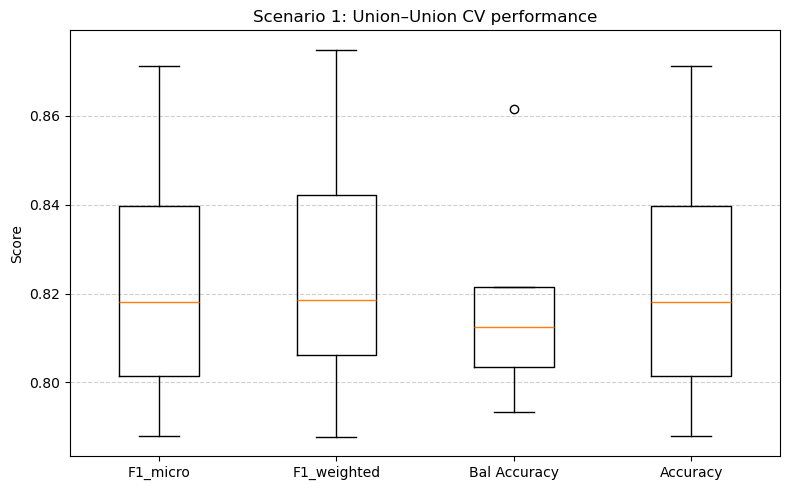

In [7]:
modalities = ["rna", "dna", "rppa"]

def inf_builder_s1(X_train, X_test):
    # Inference graph contains all union patients (all rows in feature-selected matrices)
    return {m: fs_views[m] for m in modalities}

res1 = run_cv_scenario(
    scenario_name="scenario1_union_union",
    labelled_ids=labelled_ids,
    y_all_1based=labels_1based,
    views_for_training=fs_views,              # training will be sliced to X_train inside runner
    views_for_inference_builder=inf_builder_s1,
    cfg=cfg,
    dataset_name=dataset_name,
    run_dir=paths.runs_dir,
    models_dir=paths.models_dir,
    modalities=modalities,
)

save_cv_boxplot(
    res1.metrics,
    paths.figures_dir / "scenario1_cv_boxplot.png",
    title="Scenario 1: Union–Union CV performance"
)


# Union-Union/Train

Start indexing input expression matrices!
Common sample between view0 and view1: 327
Common sample between view0 and view2: 326
Common sample between view1 and view2: 328
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 5.84232234954834s
Starting unsupervised exmbedding extraction!
Dataset 0: (398, 500)
Dataset 1: (398, 500)
Dataset 2: (395, 464)
epoch 0: loss 28.789657592773438, align_loss:0.726337
epoch 100: loss 22.68537139892578, align_loss:0.363544
epoch 200: loss 1.689622163772583, align_loss:0.190378
epoch 300: loss 1.6884021759033203, align_loss:0.189742
epoch 400: loss 1.6869823932647705, align_loss:0.189004
epoch 500: loss 1.6853935718536377, align_loss:0.188257
epoch 600: loss 1.6836599111557007, align_loss:0.187448
epoch 700: loss 1.6818045377731323, align_loss:0.186599
epoch 800: loss 1.6798354387283325, align_loss:0.185699
epoch 900: loss 1.677746057510376, align_loss:0.184854
Manifold alignment ends! Times: 17.48281478881836s
Starting supervised finetin

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/supervised_train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


epoch 0: loss 5.1455817222595215, kl_loss:2.856346, align_loss:0.752461, clf_loss:1.536775
epoch 100: loss 1.9108595848083496, kl_loss:1.622124, align_loss:0.183393, clf_loss:0.105342
epoch 200: loss 1.781566858291626, kl_loss:1.594860, align_loss:0.170961, clf_loss:0.015746
epoch 300: loss 1.7762386798858643, kl_loss:1.591166, align_loss:0.170680, clf_loss:0.014393
epoch 400: loss 1.7704992294311523, kl_loss:1.586874, align_loss:0.170378, clf_loss:0.013247
epoch 500: loss 1.7645119428634644, kl_loss:1.582270, align_loss:0.170010, clf_loss:0.012232
epoch 600: loss 1.758273959159851, kl_loss:1.577276, align_loss:0.169698, clf_loss:0.011300
epoch 700: loss 1.7518092393875122, kl_loss:1.572050, align_loss:0.169328, clf_loss:0.010431
Manifold alignment ends! Times: 20.606927156448364s
Start indexing input expression matrices!
Common sample between view0 and view1: 88
Common sample between view0 and view2: 88
Common sample between view1 and view2: 86
Neighbor size: 20
Start applying diffusi

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/integrater.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loc

Diffusion ends! Times: 5.698152780532837s
Starting unsupervised exmbedding extraction!
Dataset 0: (397, 500)
Dataset 1: (397, 500)
Dataset 2: (400, 464)
epoch 0: loss 28.6290340423584, align_loss:0.711014
epoch 100: loss 22.693878173828125, align_loss:0.386165
epoch 200: loss 1.6968696117401123, align_loss:0.192382
epoch 300: loss 1.6955238580703735, align_loss:0.191592
epoch 400: loss 1.6939702033996582, align_loss:0.190795
epoch 500: loss 1.6922404766082764, align_loss:0.189828
epoch 600: loss 1.6903331279754639, align_loss:0.188848
epoch 700: loss 1.6882860660552979, align_loss:0.187956
epoch 800: loss 1.6860761642456055, align_loss:0.186964
epoch 900: loss 1.6837382316589355, align_loss:0.185987
Manifold alignment ends! Times: 18.226085901260376s
Starting supervised fineting!
Dataset 0: (397, 500)
Dataset 1: (397, 500)
Dataset 2: (400, 464)
IntegrAO(
  (feature): ModuleList(
    (0-1): 2 x GraphSAGE(500, 64, num_layers=2)
    (2): GraphSAGE(464, 64, num_layers=2)
  )
  (feature_sho

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/supervised_train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


epoch 100: loss 2.054370641708374, kl_loss:1.696018, align_loss:0.173772, clf_loss:0.184580
epoch 200: loss 1.8978469371795654, kl_loss:1.660429, align_loss:0.166693, clf_loss:0.070726
epoch 300: loss 1.884023904800415, kl_loss:1.656835, align_loss:0.166684, clf_loss:0.060505
epoch 400: loss 1.8689162731170654, kl_loss:1.652747, align_loss:0.166552, clf_loss:0.049617
epoch 500: loss 1.8541197776794434, kl_loss:1.647373, align_loss:0.166439, clf_loss:0.040307
epoch 600: loss 1.8358008861541748, kl_loss:1.640721, align_loss:0.166997, clf_loss:0.028083
epoch 700: loss 1.821627140045166, kl_loss:1.634998, align_loss:0.165857, clf_loss:0.020773
Manifold alignment ends! Times: 19.95624303817749s
Start indexing input expression matrices!
Common sample between view0 and view1: 86
Common sample between view0 and view2: 84
Common sample between view1 and view2: 88
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 1.6960880756378174s
IntegrAO(
  (feature): ModuleList(
    (0-1): 

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/integrater.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loc

Diffusion ends! Times: 5.6070122718811035s
Starting unsupervised exmbedding extraction!
Dataset 0: (406, 500)
Dataset 1: (405, 500)
Dataset 2: (399, 464)
epoch 0: loss 28.422731399536133, align_loss:0.740496
epoch 100: loss 22.82235336303711, align_loss:0.382364
epoch 200: loss 1.7351927757263184, align_loss:0.197463
epoch 300: loss 1.733985185623169, align_loss:0.196819
epoch 400: loss 1.7325719594955444, align_loss:0.196023
epoch 500: loss 1.730932354927063, align_loss:0.195173
epoch 600: loss 1.7291055917739868, align_loss:0.194306
epoch 700: loss 1.7271366119384766, align_loss:0.193388
epoch 800: loss 1.7250146865844727, align_loss:0.192462
epoch 900: loss 1.722714900970459, align_loss:0.191601
Manifold alignment ends! Times: 17.56271195411682s
Starting supervised fineting!
Dataset 0: (406, 500)
Dataset 1: (405, 500)
Dataset 2: (399, 464)
IntegrAO(
  (feature): ModuleList(
    (0-1): 2 x GraphSAGE(500, 64, num_layers=2)
    (2): GraphSAGE(464, 64, num_layers=2)
  )
  (feature_show)

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/supervised_train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


epoch 100: loss 2.643005847930908, kl_loss:1.702343, align_loss:0.269005, clf_loss:0.671658
epoch 200: loss 1.7817492485046387, kl_loss:1.603963, align_loss:0.168030, clf_loss:0.009757
epoch 300: loss 1.7765460014343262, kl_loss:1.599970, align_loss:0.167683, clf_loss:0.008893
epoch 400: loss 1.7709641456604004, kl_loss:1.595511, align_loss:0.167343, clf_loss:0.008111
epoch 500: loss 1.7650552988052368, kl_loss:1.590635, align_loss:0.167036, clf_loss:0.007384
epoch 600: loss 1.7589550018310547, kl_loss:1.585768, align_loss:0.166443, clf_loss:0.006744
epoch 700: loss 1.7526785135269165, kl_loss:1.580649, align_loss:0.165891, clf_loss:0.006138
Manifold alignment ends! Times: 20.39683198928833s
Start indexing input expression matrices!
Common sample between view0 and view1: 74
Common sample between view0 and view2: 79
Common sample between view1 and view2: 79
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 1.5769529342651367s
IntegrAO(
  (feature): ModuleList(
    (0-1)

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/integrater.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loc

Diffusion ends! Times: 5.749585866928101s
Starting unsupervised exmbedding extraction!
Dataset 0: (403, 500)
Dataset 1: (398, 500)
Dataset 2: (403, 464)
epoch 0: loss 28.652088165283203, align_loss:0.735042
epoch 100: loss 22.94358253479004, align_loss:0.395304
epoch 200: loss 1.7687524557113647, align_loss:0.199355
epoch 300: loss 1.7675750255584717, align_loss:0.198998
epoch 400: loss 1.7662208080291748, align_loss:0.198398
epoch 500: loss 1.7646965980529785, align_loss:0.197741
epoch 600: loss 1.7629860639572144, align_loss:0.197071
epoch 700: loss 1.7611279487609863, align_loss:0.196474
epoch 800: loss 1.7591848373413086, align_loss:0.195884
epoch 900: loss 1.7571892738342285, align_loss:0.195354
Manifold alignment ends! Times: 17.64497399330139s
Starting supervised fineting!
Dataset 0: (403, 500)
Dataset 1: (398, 500)
Dataset 2: (403, 464)
IntegrAO(
  (feature): ModuleList(
    (0-1): 2 x GraphSAGE(500, 64, num_layers=2)
    (2): GraphSAGE(464, 64, num_layers=2)
  )
  (feature_sho

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/supervised_train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


epoch 0: loss 5.033358573913574, kl_loss:2.805770, align_loss:0.733917, clf_loss:1.493672
epoch 100: loss 1.7968034744262695, kl_loss:1.606866, align_loss:0.169904, clf_loss:0.020033
epoch 200: loss 1.7398351430892944, kl_loss:1.559676, align_loss:0.169758, clf_loss:0.010401
epoch 300: loss 1.7352629899978638, kl_loss:1.556488, align_loss:0.169317, clf_loss:0.009457
epoch 400: loss 1.7301206588745117, kl_loss:1.552950, align_loss:0.168652, clf_loss:0.008519
epoch 500: loss 1.7245689630508423, kl_loss:1.548958, align_loss:0.167948, clf_loss:0.007662
epoch 600: loss 1.7185372114181519, kl_loss:1.544490, align_loss:0.167167, clf_loss:0.006880
epoch 700: loss 1.7124133110046387, kl_loss:1.539855, align_loss:0.166375, clf_loss:0.006183
Manifold alignment ends! Times: 20.478991985321045s
Start indexing input expression matrices!
Common sample between view0 and view1: 83
Common sample between view0 and view2: 80
Common sample between view1 and view2: 79
Neighbor size: 20
Start applying diffus

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/integrater.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loc

Diffusion ends! Times: 6.333971977233887s
Starting unsupervised exmbedding extraction!
Dataset 0: (396, 500)
Dataset 1: (402, 500)
Dataset 2: (403, 464)
epoch 0: loss 28.451799392700195, align_loss:0.742172
epoch 100: loss 22.663898468017578, align_loss:0.406706
epoch 200: loss 1.69352388381958, align_loss:0.198207
epoch 300: loss 1.6919718980789185, align_loss:0.197331
epoch 400: loss 1.690138578414917, align_loss:0.196441
epoch 500: loss 1.6880767345428467, align_loss:0.195584
epoch 600: loss 1.685835838317871, align_loss:0.194677
epoch 700: loss 1.6834250688552856, align_loss:0.193763
epoch 800: loss 1.680840253829956, align_loss:0.192844
epoch 900: loss 1.6780569553375244, align_loss:0.191898
Manifold alignment ends! Times: 21.19832181930542s
Starting supervised fineting!
Dataset 0: (396, 500)
Dataset 1: (402, 500)
Dataset 2: (403, 464)
IntegrAO(
  (feature): ModuleList(
    (0-1): 2 x GraphSAGE(500, 64, num_layers=2)
    (2): GraphSAGE(464, 64, num_layers=2)
  )
  (feature_show): 

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/supervised_train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


epoch 0: loss 4.864889144897461, kl_loss:2.774462, align_loss:0.689099, clf_loss:1.401328
epoch 100: loss 2.0201189517974854, kl_loss:1.739338, align_loss:0.168354, clf_loss:0.112427
epoch 200: loss 1.8886972665786743, kl_loss:1.699350, align_loss:0.165601, clf_loss:0.023746
epoch 300: loss 1.8811471462249756, kl_loss:1.695087, align_loss:0.165217, clf_loss:0.020843
epoch 400: loss 1.873460292816162, kl_loss:1.689782, align_loss:0.165195, clf_loss:0.018483
epoch 500: loss 1.8657257556915283, kl_loss:1.684433, align_loss:0.164788, clf_loss:0.016505
epoch 600: loss 1.8582161664962769, kl_loss:1.678864, align_loss:0.164431, clf_loss:0.014921
epoch 700: loss 1.850643277168274, kl_loss:1.673427, align_loss:0.163982, clf_loss:0.013234
Manifold alignment ends! Times: 21.25436782836914s
Start indexing input expression matrices!
Common sample between view0 and view1: 84
Common sample between view0 and view2: 83
Common sample between view1 and view2: 82
Neighbor size: 20
Start applying diffusion

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/integrater.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loc

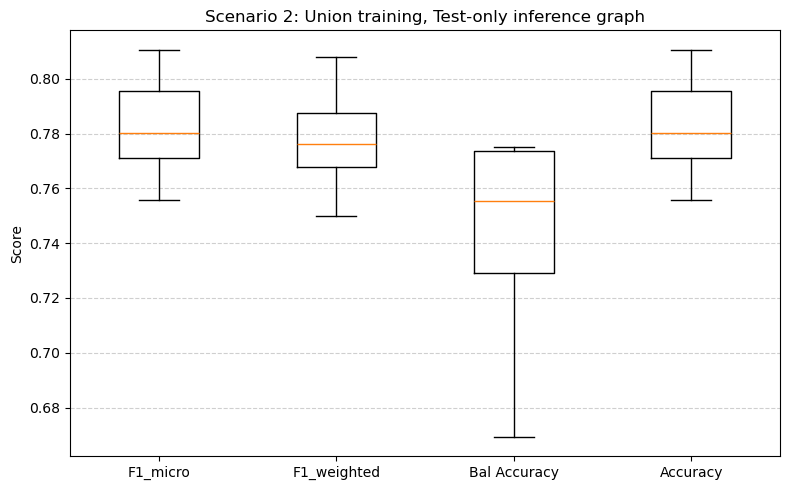

In [8]:
def inf_builder_s2(X_train, X_test):
    # Inference graph contains only test patients
    return {m: fs_views[m].loc[X_test] for m in modalities}

res2 = run_cv_scenario(
    scenario_name="scenario2_union_testonly",
    labelled_ids=labelled_ids,
    y_all_1based=labels_1based,
    views_for_training=fs_views,
    views_for_inference_builder=inf_builder_s2,
    cfg=cfg,
    dataset_name=dataset_name,
    run_dir=paths.runs_dir,
    models_dir=paths.models_dir,
    modalities=modalities,
)

save_cv_boxplot(
    res2.metrics,
    paths.figures_dir / "scenario2_cv_boxplot.png",
    title="Scenario 2: Union training, Test-only inference graph"
)


# Intersection-Union

Complete-data (intersection) labelled: 401
Start indexing input expression matrices!
Common sample between view0 and view1: 320
Common sample between view0 and view2: 320
Common sample between view1 and view2: 320
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 2.15151309967041s
Starting unsupervised exmbedding extraction!
Dataset 0: (320, 500)
Dataset 1: (320, 500)
Dataset 2: (320, 464)
epoch 0: loss 23.63939666748047, align_loss:0.770702
epoch 100: loss 19.885507583618164, align_loss:0.224790
epoch 200: loss 0.9299863576889038, align_loss:0.126725
epoch 300: loss 0.9292858242988586, align_loss:0.126248
epoch 400: loss 0.9284812211990356, align_loss:0.125749
epoch 500: loss 0.9275844097137451, align_loss:0.125211
epoch 600: loss 0.9266072511672974, align_loss:0.124687
epoch 700: loss 0.9255546927452087, align_loss:0.124138
epoch 800: loss 0.9244384169578552, align_loss:0.123585
epoch 900: loss 0.9232544302940369, align_loss:0.123039
Manifold alignment ends! Times: 1

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/supervised_train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


epoch 100: loss 1.2055244445800781, kl_loss:0.992409, align_loss:0.129129, clf_loss:0.083986
epoch 200: loss 1.0463132858276367, kl_loss:0.938730, align_loss:0.103053, clf_loss:0.004530
epoch 300: loss 1.0432662963867188, kl_loss:0.935838, align_loss:0.103297, clf_loss:0.004131
epoch 400: loss 1.0398023128509521, kl_loss:0.932540, align_loss:0.103552, clf_loss:0.003710
epoch 500: loss 1.0360006093978882, kl_loss:0.928512, align_loss:0.104103, clf_loss:0.003385
epoch 600: loss 1.0320008993148804, kl_loss:0.924429, align_loss:0.104431, clf_loss:0.003140
epoch 700: loss 1.0277782678604126, kl_loss:0.920014, align_loss:0.104845, clf_loss:0.002920
Manifold alignment ends! Times: 15.719444990158081s
Start indexing input expression matrices!
Common sample between view0 and view1: 415
Common sample between view0 and view2: 414
Common sample between view1 and view2: 414
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 7.4543421268463135s
IntegrAO(
  (feature): ModuleList(
    

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/integrater.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loc

Common sample between view1 and view2: 321
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 2.010125160217285s
Starting unsupervised exmbedding extraction!
Dataset 0: (321, 500)
Dataset 1: (321, 500)
Dataset 2: (321, 464)
epoch 0: loss 23.992992401123047, align_loss:0.726927
epoch 100: loss 19.87005043029785, align_loss:0.225108
epoch 200: loss 0.9261990189552307, align_loss:0.127570
epoch 300: loss 0.9254030585289001, align_loss:0.126990
epoch 400: loss 0.9244734048843384, align_loss:0.126426
epoch 500: loss 0.9233807325363159, align_loss:0.125925
epoch 600: loss 0.922243595123291, align_loss:0.125335
epoch 700: loss 0.9210414886474609, align_loss:0.124748
epoch 800: loss 0.919768214225769, align_loss:0.124223
epoch 900: loss 0.9183844923973083, align_loss:0.123694
Manifold alignment ends! Times: 14.038089990615845s
Starting supervised fineting!
Dataset 0: (321, 500)
Dataset 1: (321, 500)
Dataset 2: (321, 464)
IntegrAO(
  (feature): ModuleList(
    (0-1): 2 x GraphSA

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/supervised_train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


epoch 100: loss 1.1186590194702148, kl_loss:0.990364, align_loss:0.108452, clf_loss:0.019843
epoch 200: loss 1.0806593894958496, kl_loss:0.967345, align_loss:0.103533, clf_loss:0.009781
epoch 300: loss 1.0768935680389404, kl_loss:0.964513, align_loss:0.103191, clf_loss:0.009190
epoch 400: loss 1.0724718570709229, kl_loss:0.960828, align_loss:0.103116, clf_loss:0.008528
epoch 500: loss 1.0673245191574097, kl_loss:0.956487, align_loss:0.102995, clf_loss:0.007843
epoch 600: loss 1.0615798234939575, kl_loss:0.951304, align_loss:0.103172, clf_loss:0.007104
epoch 700: loss 1.055210828781128, kl_loss:0.945198, align_loss:0.103532, clf_loss:0.006481
Manifold alignment ends! Times: 15.313544034957886s
Start indexing input expression matrices!
Common sample between view0 and view1: 415
Common sample between view0 and view2: 414
Common sample between view1 and view2: 414
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 7.154114723205566s
IntegrAO(
  (feature): ModuleList(
    (0

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/integrater.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loc

Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 1.988128900527954s
Starting unsupervised exmbedding extraction!
Dataset 0: (321, 500)
Dataset 1: (321, 500)
Dataset 2: (321, 464)
epoch 0: loss 23.8958683013916, align_loss:0.787853
epoch 100: loss 19.951162338256836, align_loss:0.226741
epoch 200: loss 0.9445825815200806, align_loss:0.124311
epoch 300: loss 0.9438013434410095, align_loss:0.123896
epoch 400: loss 0.9429064393043518, align_loss:0.123374
epoch 500: loss 0.9419054985046387, align_loss:0.122817
epoch 600: loss 0.9408168196678162, align_loss:0.122236
epoch 700: loss 0.9396495819091797, align_loss:0.121675
epoch 800: loss 0.9383987188339233, align_loss:0.121069
epoch 900: loss 0.9370442032814026, align_loss:0.120459
Manifold alignment ends! Times: 13.841817855834961s
Starting supervised fineting!
Dataset 0: (321, 500)
Dataset 1: (321, 500)
Dataset 2: (321, 464)
IntegrAO(
  (feature): ModuleList(
    (0-1): 2 x GraphSAGE(500, 64, num_layers=2)
    (2): GraphSA

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/supervised_train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


epoch 100: loss 1.089326024055481, kl_loss:0.975718, align_loss:0.099454, clf_loss:0.014154
epoch 200: loss 1.0289877653121948, kl_loss:0.927885, align_loss:0.096429, clf_loss:0.004673
epoch 300: loss 1.0248425006866455, kl_loss:0.924023, align_loss:0.096494, clf_loss:0.004325
epoch 400: loss 1.0199929475784302, kl_loss:0.919500, align_loss:0.096531, clf_loss:0.003963
epoch 500: loss 1.0144548416137695, kl_loss:0.914229, align_loss:0.096635, clf_loss:0.003591
epoch 600: loss 1.0084642171859741, kl_loss:0.908443, align_loss:0.096748, clf_loss:0.003273
epoch 700: loss 1.0020408630371094, kl_loss:0.902309, align_loss:0.096812, clf_loss:0.002920
Manifold alignment ends! Times: 15.025380849838257s
Start indexing input expression matrices!
Common sample between view0 and view1: 415
Common sample between view0 and view2: 414
Common sample between view1 and view2: 414
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 7.036497116088867s
IntegrAO(
  (feature): ModuleList(
    (0

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/integrater.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loc

Start applying diffusion!
Diffusion ends! Times: 2.0585711002349854s
Starting unsupervised exmbedding extraction!
Dataset 0: (321, 500)
Dataset 1: (321, 500)
Dataset 2: (321, 464)
epoch 0: loss 23.67881965637207, align_loss:0.701796
epoch 100: loss 19.819963455200195, align_loss:0.229394
epoch 200: loss 0.9092757701873779, align_loss:0.125804
epoch 300: loss 0.9082967042922974, align_loss:0.125314
epoch 400: loss 0.9071566462516785, align_loss:0.124779
epoch 500: loss 0.905868411064148, align_loss:0.124227
epoch 600: loss 0.9044546484947205, align_loss:0.123644
epoch 700: loss 0.9029443860054016, align_loss:0.123055
epoch 800: loss 0.9013335704803467, align_loss:0.122449
epoch 900: loss 0.8996210694313049, align_loss:0.121840
Manifold alignment ends! Times: 13.655108213424683s
Starting supervised fineting!
Dataset 0: (321, 500)
Dataset 1: (321, 500)
Dataset 2: (321, 464)
IntegrAO(
  (feature): ModuleList(
    (0-1): 2 x GraphSAGE(500, 64, num_layers=2)
    (2): GraphSAGE(464, 64, num_l

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/supervised_train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


epoch 100: loss 1.0683611631393433, kl_loss:0.946664, align_loss:0.115765, clf_loss:0.005932
epoch 200: loss 1.0375334024429321, kl_loss:0.924988, align_loss:0.107939, clf_loss:0.004606
epoch 300: loss 1.0349379777908325, kl_loss:0.922838, align_loss:0.107623, clf_loss:0.004477
epoch 400: loss 1.0319265127182007, kl_loss:0.920296, align_loss:0.107299, clf_loss:0.004331
epoch 500: loss 1.028552532196045, kl_loss:0.917495, align_loss:0.106897, clf_loss:0.004161
epoch 600: loss 1.02481210231781, kl_loss:0.914418, align_loss:0.106373, clf_loss:0.004020
epoch 700: loss 1.0208334922790527, kl_loss:0.911042, align_loss:0.105932, clf_loss:0.003859
Manifold alignment ends! Times: 15.126375913619995s
Start indexing input expression matrices!
Common sample between view0 and view1: 415
Common sample between view0 and view2: 414
Common sample between view1 and view2: 414
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 7.407480001449585s
IntegrAO(
  (feature): ModuleList(
    (0-1

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/integrater.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loc

Start applying diffusion!
Diffusion ends! Times: 1.9538428783416748s
Starting unsupervised exmbedding extraction!
Dataset 0: (321, 500)
Dataset 1: (321, 500)
Dataset 2: (321, 464)
epoch 0: loss 23.719602584838867, align_loss:0.757857
epoch 100: loss 19.942298889160156, align_loss:0.222099
epoch 200: loss 0.9420971274375916, align_loss:0.125801
epoch 300: loss 0.9412946701049805, align_loss:0.125284
epoch 400: loss 0.9403746128082275, align_loss:0.124739
epoch 500: loss 0.9393567442893982, align_loss:0.124147
epoch 600: loss 0.93825364112854, align_loss:0.123535
epoch 700: loss 0.9370627999305725, align_loss:0.122911
epoch 800: loss 0.9357908964157104, align_loss:0.122296
epoch 900: loss 0.934442937374115, align_loss:0.121676
Manifold alignment ends! Times: 14.030565023422241s
Starting supervised fineting!
Dataset 0: (321, 500)
Dataset 1: (321, 500)
Dataset 2: (321, 464)
IntegrAO(
  (feature): ModuleList(
    (0-1): 2 x GraphSAGE(500, 64, num_layers=2)
    (2): GraphSAGE(464, 64, num_la

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/supervised_train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


epoch 100: loss 1.0942339897155762, kl_loss:0.977840, align_loss:0.108206, clf_loss:0.008188
epoch 200: loss 1.0520524978637695, kl_loss:0.939005, align_loss:0.107717, clf_loss:0.005330
epoch 300: loss 1.0488747358322144, kl_loss:0.936007, align_loss:0.107745, clf_loss:0.005122
epoch 400: loss 1.0451266765594482, kl_loss:0.932482, align_loss:0.107773, clf_loss:0.004871
epoch 500: loss 1.0409390926361084, kl_loss:0.928538, align_loss:0.107837, clf_loss:0.004564
epoch 600: loss 1.0363801717758179, kl_loss:0.924325, align_loss:0.107848, clf_loss:0.004207
epoch 700: loss 1.0313924551010132, kl_loss:0.919481, align_loss:0.108026, clf_loss:0.003886
Manifold alignment ends! Times: 15.362714052200317s
Start indexing input expression matrices!
Common sample between view0 and view1: 415
Common sample between view0 and view2: 414
Common sample between view1 and view2: 414
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 7.2264838218688965s
IntegrAO(
  (feature): ModuleList(
    

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/integrater.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loc

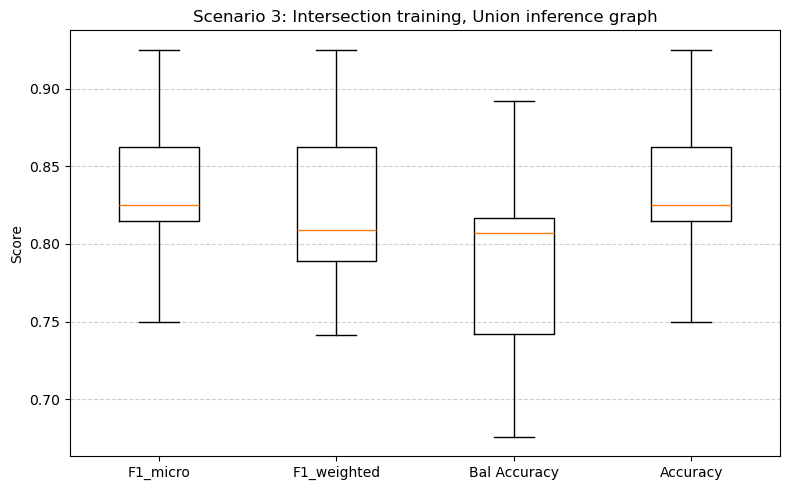

In [9]:
complete_ids = fs_views["rna"].dropna().index \
    .intersection(fs_views["dna"].dropna().index) \
    .intersection(fs_views["rppa"].dropna().index)

complete_ids = labelled_ids.intersection(complete_ids)
print("Complete-data (intersection) labelled:", len(complete_ids))

def inf_builder_s3(X_train, X_test):
    return {m: fs_views[m] for m in modalities}

res3 = run_cv_scenario(
    scenario_name="scenario3_intersection_train_union_infer",
    labelled_ids=complete_ids,               # split only over intersection
    y_all_1based=labels_1based,
    views_for_training=fs_views,
    views_for_inference_builder=inf_builder_s3,
    cfg=cfg,
    dataset_name=dataset_name,
    run_dir=paths.runs_dir,
    models_dir=paths.models_dir,
    modalities=modalities,
)

save_cv_boxplot(
    res3.metrics,
    paths.figures_dir / "scenario3_cv_boxplot.png",
    title="Scenario 3: Intersection training, Union inference graph"
)


# Intersection-Union/Train

Start indexing input expression matrices!
Common sample between view0 and view1: 320
Common sample between view0 and view2: 320
Common sample between view1 and view2: 320
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 2.246342897415161s
Starting unsupervised exmbedding extraction!
Dataset 0: (320, 500)
Dataset 1: (320, 500)
Dataset 2: (320, 464)
epoch 0: loss 23.680631637573242, align_loss:0.768302
epoch 100: loss 19.755664825439453, align_loss:0.234607
epoch 200: loss 0.8971118330955505, align_loss:0.127013
epoch 300: loss 0.8961568474769592, align_loss:0.126438
epoch 400: loss 0.8950458765029907, align_loss:0.125853
epoch 500: loss 0.8938173055648804, align_loss:0.125222
epoch 600: loss 0.8924688696861267, align_loss:0.124575
epoch 700: loss 0.8910071849822998, align_loss:0.123915
epoch 800: loss 0.8894153833389282, align_loss:0.123315
epoch 900: loss 0.887739896774292, align_loss:0.122607
Manifold alignment ends! Times: 14.424860954284668s
Starting supervised fin

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/supervised_train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


epoch 100: loss 1.0376051664352417, kl_loss:0.931174, align_loss:0.100231, clf_loss:0.006200
epoch 200: loss 1.019289493560791, kl_loss:0.914992, align_loss:0.100159, clf_loss:0.004139
epoch 300: loss 1.0174967050552368, kl_loss:0.913319, align_loss:0.100195, clf_loss:0.003983
epoch 400: loss 1.015413761138916, kl_loss:0.911393, align_loss:0.100205, clf_loss:0.003816
epoch 500: loss 1.0130983591079712, kl_loss:0.909236, align_loss:0.100236, clf_loss:0.003626
epoch 600: loss 1.0105780363082886, kl_loss:0.906902, align_loss:0.100264, clf_loss:0.003412
epoch 700: loss 1.007867455482483, kl_loss:0.904309, align_loss:0.100352, clf_loss:0.003206
Manifold alignment ends! Times: 15.651540994644165s
Start indexing input expression matrices!
Common sample between view0 and view1: 95
Common sample between view0 and view2: 94
Common sample between view1 and view2: 94
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 2.415672779083252s
IntegrAO(
  (feature): ModuleList(
    (0-1): 

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/integrater.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loc

Diffusion ends! Times: 1.9980058670043945s
Starting unsupervised exmbedding extraction!
Dataset 0: (321, 500)
Dataset 1: (321, 500)
Dataset 2: (321, 464)
epoch 0: loss 23.96244239807129, align_loss:0.747816
epoch 100: loss 19.91634750366211, align_loss:0.245675
epoch 200: loss 0.9435514211654663, align_loss:0.134627
epoch 300: loss 0.9426165819168091, align_loss:0.133896
epoch 400: loss 0.9415396451950073, align_loss:0.133216
epoch 500: loss 0.9403447508811951, align_loss:0.132457
epoch 600: loss 0.9390338063240051, align_loss:0.131698
epoch 700: loss 0.9376415610313416, align_loss:0.130890
epoch 800: loss 0.9361354112625122, align_loss:0.130138
epoch 900: loss 0.934538722038269, align_loss:0.129501
Manifold alignment ends! Times: 14.262576818466187s
Starting supervised fineting!
Dataset 0: (321, 500)
Dataset 1: (321, 500)
Dataset 2: (321, 464)
IntegrAO(
  (feature): ModuleList(
    (0-1): 2 x GraphSAGE(500, 64, num_layers=2)
    (2): GraphSAGE(464, 64, num_layers=2)
  )
  (feature_sho

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/supervised_train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


epoch 100: loss 1.077609896659851, kl_loss:0.951577, align_loss:0.115853, clf_loss:0.010180
epoch 200: loss 1.032217025756836, kl_loss:0.919452, align_loss:0.108130, clf_loss:0.004635
epoch 300: loss 1.0287977457046509, kl_loss:0.916437, align_loss:0.107987, clf_loss:0.004373
epoch 400: loss 1.0248948335647583, kl_loss:0.912804, align_loss:0.107994, clf_loss:0.004096
epoch 500: loss 1.0206342935562134, kl_loss:0.909067, align_loss:0.107761, clf_loss:0.003806
epoch 600: loss 1.0159755945205688, kl_loss:0.904674, align_loss:0.107728, clf_loss:0.003574
epoch 700: loss 1.0109928846359253, kl_loss:0.899960, align_loss:0.107672, clf_loss:0.003360
Manifold alignment ends! Times: 15.59649109840393s
Start indexing input expression matrices!
Common sample between view0 and view1: 94
Common sample between view0 and view2: 93
Common sample between view1 and view2: 93
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 2.297402858734131s
IntegrAO(
  (feature): ModuleList(
    (0-1): 

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/integrater.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loc

Diffusion ends! Times: 2.036212921142578s
Starting unsupervised exmbedding extraction!
Dataset 0: (321, 500)
Dataset 1: (321, 500)
Dataset 2: (321, 464)
epoch 0: loss 23.880186080932617, align_loss:0.770288
epoch 100: loss 19.847801208496094, align_loss:0.217164
epoch 200: loss 0.9141078591346741, align_loss:0.122854
epoch 300: loss 0.9131175875663757, align_loss:0.122238
epoch 400: loss 0.9119821190834045, align_loss:0.121557
epoch 500: loss 0.9107238054275513, align_loss:0.120887
epoch 600: loss 0.9093513488769531, align_loss:0.120278
epoch 700: loss 0.9078933596611023, align_loss:0.119636
epoch 800: loss 0.9063608050346375, align_loss:0.119056
epoch 900: loss 0.9047510623931885, align_loss:0.118514
Manifold alignment ends! Times: 14.373976707458496s
Starting supervised fineting!
Dataset 0: (321, 500)
Dataset 1: (321, 500)
Dataset 2: (321, 464)
IntegrAO(
  (feature): ModuleList(
    (0-1): 2 x GraphSAGE(500, 64, num_layers=2)
    (2): GraphSAGE(464, 64, num_layers=2)
  )
  (feature_s

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/supervised_train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


epoch 100: loss 1.0516979694366455, kl_loss:0.936627, align_loss:0.102462, clf_loss:0.012609
epoch 200: loss 1.0240390300750732, kl_loss:0.918359, align_loss:0.100817, clf_loss:0.004863
epoch 300: loss 1.0215578079223633, kl_loss:0.916512, align_loss:0.100634, clf_loss:0.004411
epoch 400: loss 1.018710732460022, kl_loss:0.914282, align_loss:0.100487, clf_loss:0.003941
epoch 500: loss 1.0155646800994873, kl_loss:0.911731, align_loss:0.100366, clf_loss:0.003468
epoch 600: loss 1.0121712684631348, kl_loss:0.908965, align_loss:0.100167, clf_loss:0.003040
epoch 700: loss 1.008569359779358, kl_loss:0.905903, align_loss:0.100035, clf_loss:0.002631
Manifold alignment ends! Times: 16.47442889213562s
Start indexing input expression matrices!
Common sample between view0 and view1: 94
Common sample between view0 and view2: 93
Common sample between view1 and view2: 93
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 2.1987509727478027s
IntegrAO(
  (feature): ModuleList(
    (0-1):

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/integrater.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loc

Diffusion ends! Times: 2.0553810596466064s
Starting unsupervised exmbedding extraction!
Dataset 0: (321, 500)
Dataset 1: (321, 500)
Dataset 2: (321, 464)
epoch 0: loss 23.900524139404297, align_loss:0.778878
epoch 100: loss 19.88127899169922, align_loss:0.233132
epoch 200: loss 0.9247543811798096, align_loss:0.127876
epoch 300: loss 0.9236578345298767, align_loss:0.127314
epoch 400: loss 0.9223616123199463, align_loss:0.126781
epoch 500: loss 0.9208675622940063, align_loss:0.126256
epoch 600: loss 0.919191837310791, align_loss:0.125763
epoch 700: loss 0.9173501133918762, align_loss:0.125232
epoch 800: loss 0.9153572916984558, align_loss:0.124725
epoch 900: loss 0.9132654070854187, align_loss:0.124287
Manifold alignment ends! Times: 13.322314023971558s
Starting supervised fineting!
Dataset 0: (321, 500)
Dataset 1: (321, 500)
Dataset 2: (321, 464)
IntegrAO(
  (feature): ModuleList(
    (0-1): 2 x GraphSAGE(500, 64, num_layers=2)
    (2): GraphSAGE(464, 64, num_layers=2)
  )
  (feature_sh

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/supervised_train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


epoch 100: loss 1.1016570329666138, kl_loss:0.968729, align_loss:0.120373, clf_loss:0.012556
epoch 200: loss 1.0338672399520874, kl_loss:0.916300, align_loss:0.113333, clf_loss:0.004233
epoch 300: loss 1.030191421508789, kl_loss:0.913387, align_loss:0.112774, clf_loss:0.004030
epoch 400: loss 1.026126742362976, kl_loss:0.910042, align_loss:0.112251, clf_loss:0.003834
epoch 500: loss 1.0216752290725708, kl_loss:0.906224, align_loss:0.111842, clf_loss:0.003610
epoch 600: loss 1.0170811414718628, kl_loss:0.902301, align_loss:0.111391, clf_loss:0.003389
epoch 700: loss 1.012211561203003, kl_loss:0.898121, align_loss:0.110952, clf_loss:0.003139
Manifold alignment ends! Times: 17.56990909576416s
Start indexing input expression matrices!
Common sample between view0 and view1: 94
Common sample between view0 and view2: 93
Common sample between view1 and view2: 93
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 2.4731791019439697s
IntegrAO(
  (feature): ModuleList(
    (0-1): 

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/integrater.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loc

Diffusion ends! Times: 2.1480979919433594s
Starting unsupervised exmbedding extraction!
Dataset 0: (321, 500)
Dataset 1: (321, 500)
Dataset 2: (321, 464)
epoch 0: loss 23.815271377563477, align_loss:0.749570
epoch 100: loss 20.00181007385254, align_loss:0.214187
epoch 200: loss 0.9474115967750549, align_loss:0.123134
epoch 300: loss 0.94583660364151, align_loss:0.122554
epoch 400: loss 0.9439237117767334, align_loss:0.121759
epoch 500: loss 0.9415175914764404, align_loss:0.121016
epoch 600: loss 0.9377865791320801, align_loss:0.120231
epoch 700: loss 0.9345962405204773, align_loss:0.119499
epoch 800: loss 0.9316659569740295, align_loss:0.118824
epoch 900: loss 0.9289685487747192, align_loss:0.118265
Manifold alignment ends! Times: 13.595008134841919s
Starting supervised fineting!
Dataset 0: (321, 500)
Dataset 1: (321, 500)
Dataset 2: (321, 464)
IntegrAO(
  (feature): ModuleList(
    (0-1): 2 x GraphSAGE(500, 64, num_layers=2)
    (2): GraphSAGE(464, 64, num_layers=2)
  )
  (feature_sho

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/supervised_train.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


epoch 0: loss 3.8918442726135254, kl_loss:1.631588, align_loss:0.763992, clf_loss:1.496265
epoch 100: loss 1.0510787963867188, kl_loss:0.943515, align_loss:0.102047, clf_loss:0.005517
epoch 200: loss 1.0197077989578247, kl_loss:0.912717, align_loss:0.103469, clf_loss:0.003522
epoch 300: loss 1.0167189836502075, kl_loss:0.909819, align_loss:0.103511, clf_loss:0.003388
epoch 400: loss 1.0131890773773193, kl_loss:0.906277, align_loss:0.103652, clf_loss:0.003260
epoch 500: loss 1.0091015100479126, kl_loss:0.902256, align_loss:0.103727, clf_loss:0.003119
epoch 600: loss 1.0044102668762207, kl_loss:0.897561, align_loss:0.103842, clf_loss:0.003007
epoch 700: loss 0.9992606043815613, kl_loss:0.892194, align_loss:0.104195, clf_loss:0.002872
Manifold alignment ends! Times: 15.95435094833374s
Start indexing input expression matrices!
Common sample between view0 and view1: 94
Common sample between view0 and view2: 93
Common sample between view1 and view2: 93
Neighbor size: 20
Start applying diffus

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/integrater.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loc

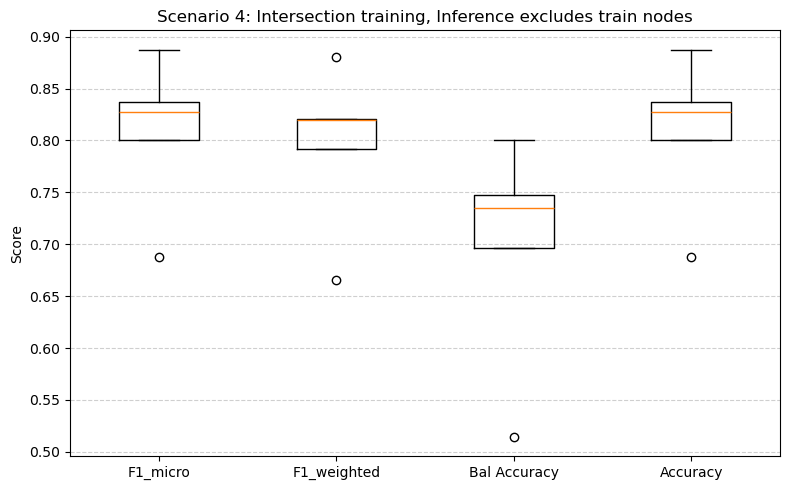

In [10]:
union_ids = fs_views["rna"].index.union(fs_views["dna"].index).union(fs_views["rppa"].index)
union_only_ids = union_ids.difference(complete_ids)  # crude "union-only" set

def inf_builder_s4(X_train, X_test):
    inference_ids = union_ids.difference(X_train)  # excludes training-fold nodes
    # ensures test patients are included
    inference_ids = inference_ids.union(X_test)
    return {m: fs_views[m].loc[fs_views[m].index.intersection(inference_ids)] for m in modalities}

res4 = run_cv_scenario(
    scenario_name="scenario4_intersection_train_testplusuniononly_infer",
    labelled_ids=complete_ids,
    y_all_1based=labels_1based,
    views_for_training=fs_views,
    views_for_inference_builder=inf_builder_s4,
    cfg=cfg,
    dataset_name=dataset_name,
    run_dir=paths.runs_dir,
    models_dir=paths.models_dir,
    modalities=modalities,
)

save_cv_boxplot(
    res4.metrics,
    paths.figures_dir / "scenario4_cv_boxplot.png",
    title="Scenario 4: Intersection training, Inference excludes train nodes"
)


# CV Results

In [11]:
import pandas as pd

def summarize_acc(metrics: "np.ndarray"):
    # metrics columns: [F1_micro, F1_weighted, Bal Accuracy, Accuracy]
    bal = metrics[:, 2]
    acc = metrics[:, 3]
    return {
        "bal_acc_mean": bal.mean(),
        "bal_acc_std": bal.std(),
        "acc_mean": acc.mean(),
        "acc_std": acc.std(),
    }

summary_rows = []
for name, res in [
    ("Scenario 1 (Union–Union)", res1),
    ("Scenario 2 (Union–Test-only)", res2),
    ("Scenario 3 (Intersection train – Union infer)", res3),
    ("Scenario 4 (Intersection train – Infer excludes train nodes)", res4),
]:
    s = summarize_acc(res.metrics)
    summary_rows.append({
        "Scenario": name,
        "Accuracy (mean ± std)": f'{s["acc_mean"]:.4f} ± {s["acc_std"]:.4f}',
        "Balanced Acc (mean ± std)": f'{s["bal_acc_mean"]:.4f} ± {s["bal_acc_std"]:.4f}',
        "acc_mean": s["acc_mean"],  # keep numeric too (optional)
        "bal_acc_mean": s["bal_acc_mean"],
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df[["Scenario", "Accuracy (mean ± std)", "Balanced Acc (mean ± std)"]])


,Scenario,Accuracy (mean ± std),Balanced Acc (mean ± std)
0,Scenario 1 (Union–Union),0.8237 ± 0.0294,0.8185 ± 0.0235
1,Scenario 2 (Union–Test-only),0.7826 ± 0.0190,0.7405 ± 0.0392
2,Scenario 3 (Intersection train – Union infer),0.8355 ± 0.0576,0.7869 ± 0.0731
3,Scenario 4 (Intersection train – Infer exclude...,0.8079 ± 0.0665,0.6989 ± 0.0980


# Feature Importance

Start indexing input expression matrices!
Common sample between view0 and view1: 415
Common sample between view0 and view2: 414
Common sample between view1 and view2: 414
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 8.32765507698059s
IntegrAO(
  (feature): ModuleList(
    (0-1): 2 x GraphSAGE(500, 64, num_layers=2)
    (2): GraphSAGE(464, 64, num_layers=2)
  )
  (feature_show): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Linear(in_features=64, out_features=64, bias=True)
  )
  (pred_head): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Linear(in_features=32, out_features=4, bias=True)
  )
)
Loaded pre-trained model 

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/integrao/integrater.py:237: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loc

,modality,feature,label,score
0,rna,ENSG00000091831.24,ESR1,0.747456
1,dna,cg23440816,cg23440816,0.720297
2,rna,ENSG00000129514.8,FOXA1,0.706951
3,rna,ENSG00000173467.9,AGR3,0.697869
4,rna,ENSG00000198729.5,PPP1R14C,0.697699
5,rppa,GATA3,GATA3,0.690795
6,rppa,ERALPHA,ERALPHA,0.684811
7,rna,ENSG00000102243.13,VGLL1,0.673110
8,dna,cg13488570,cg13488570,0.673083
9,rna,ENSG00000178568.15,ERBB4,0.669875


Legend modalities: ['rna', 'dna', 'rppa']


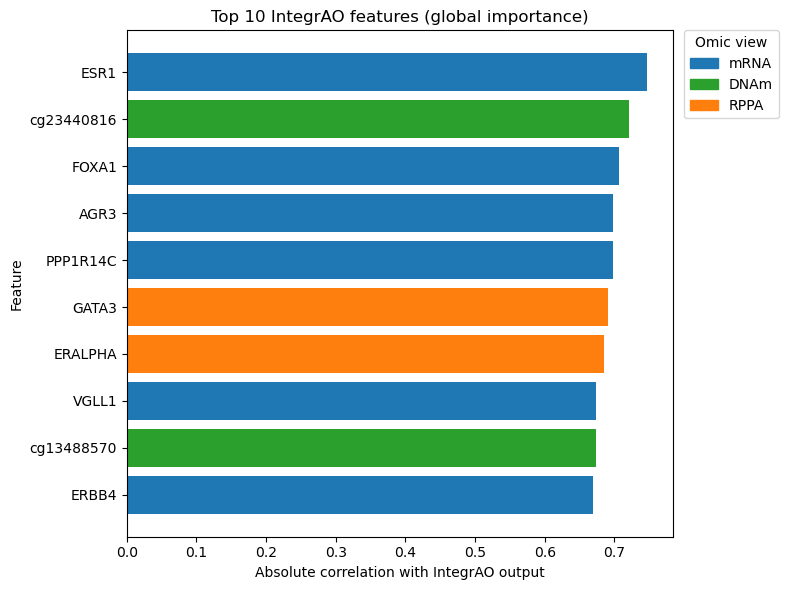

In [38]:
# Feature Importance
model_path = res1.fold_model_paths[0]

from utils.integrao_pipeline import infer_on_graph

preds, predictor, preds_index = infer_on_graph(
    model_path=model_path,
    inference_views={m: fs_views[m] for m in modalities},
    cfg=cfg,
    dataset_name=dataset_name,
    modalities=modalities,
)

fi = global_corr_importance(
    views=fs_views,
    labels_1based=labels_1based,
    preds=preds,
    preds_index=preds_index,
    top_k=10,
)

display(fi.top_k[["modality", "feature", "label", "score"]])

save_top_features_barplot(
    fi.top_k,
    paths.figures_dir / "top10_global_feature_importance.png",
    title="Top 10 IntegrAO features (global importance)"
)
